# Testing Graphical User Interfaces

In this chapter, we explore how to generate tests for Graphical User Interfaces (GUIs), abstracting from our [previous examples on Web testing](WebFuzzer.ipynb).  Building on general means to extract user interface elements and to activate them, our techniques generalize to arbitrary graphical user interfaces, from rich Web applications to mobile apps, and systematically explore user interfaces through forms and navigation elements.

**Prerequisites**

* We build on the Web server introduced in the [chapter on Web testing](WebFuzzer.ipynb).

## Automated GUI Interaction

With our Web server: no JavaScript, no rich interfaces.  Also: Limited to Web.

How can we automate interaction?

### Our Web Server, Again

We (again) run our Web server.

In [1]:
import fuzzingbook_utils

In [2]:
from fuzzingbook_utils import unicode_escape

In [3]:
from WebFuzzer import init_db, start_httpd, webbrowser, print_httpd_messages, print_url, ORDERS_DB

In [4]:
import html

In [5]:
db = init_db()

In [6]:
httpd_process, httpd_url = start_httpd()
print_url(httpd_url)

In [7]:
from IPython.core.display import display, Image
from fuzzingbook_utils import HTML, rich_output

In [8]:
HTML(webbrowser(httpd_url))

### Remote Control with Selenium

Let us just look at the GUI, above.  We do not assume we can access the HTML source, or even the URL of the current page.  All we assume is that there is a set of *user interface elements* we can interact with.

Documentation is available [here.](https://selenium-python.readthedocs.io/index.html)

In [9]:
from selenium import webdriver

In [10]:
from selenium.webdriver.firefox.options import Options

In [11]:
options = Options()
options.headless = True

In [12]:
from selenium.webdriver.firefox.firefox_profile import FirefoxProfile

In [13]:
ZOOM = 1.4
profile = FirefoxProfile()
profile.set_preference("layout.css.devPixelsPerPx", repr(ZOOM))

In [14]:
driver = webdriver.Firefox(firefox_profile=profile, options=options)

In [15]:
# Alternative: Chrome

# options = webdriver.ChromeOptions()
# options.add_argument('headless')
# options.add_argument('window-size=700x230')
# driver = webdriver.Chrome(options=options)

In [16]:
driver.get(httpd_url)

In [17]:
print_httpd_messages()

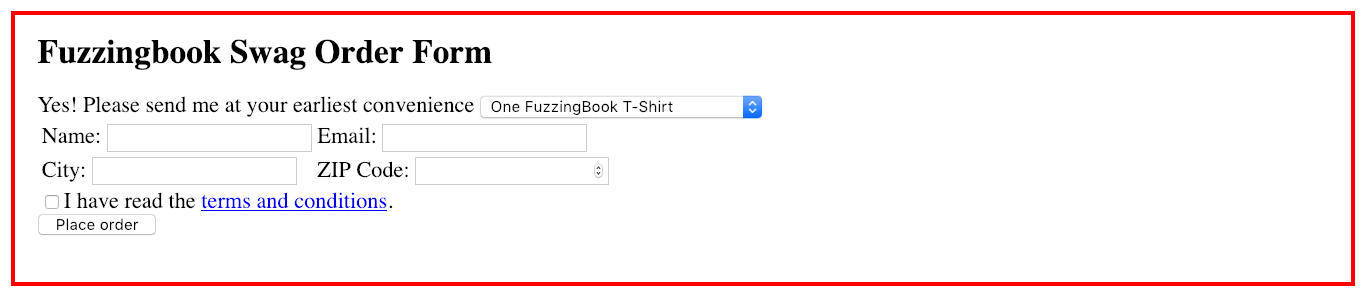

In [18]:
Image(driver.get_screenshot_as_png())

### Filling out Forms

In [19]:
name = driver.find_element_by_name("name")
name.send_keys("Jane Doe")

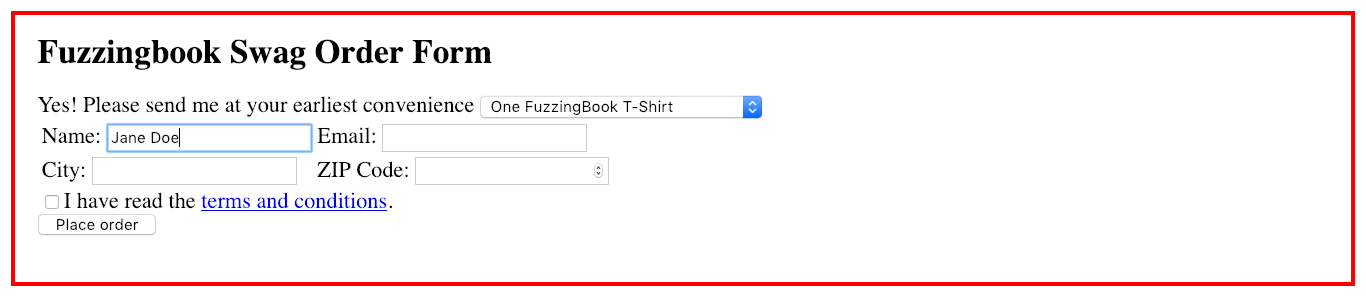

In [20]:
Image(driver.get_screenshot_as_png())

In [21]:
email = driver.find_element_by_name("email")
email.send_keys("j.doe@example.com")

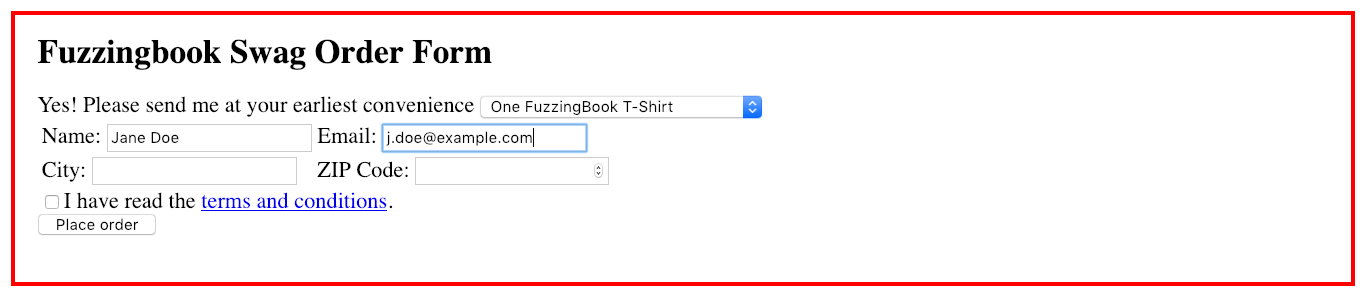

In [22]:
Image(driver.get_screenshot_as_png())

In [23]:
city = driver.find_element_by_name('city')
city.send_keys("Seattle")

In [24]:
zip = driver.find_element_by_name('zip')
zip.send_keys("98104")

In [25]:
terms = driver.find_element_by_name('terms')
terms.click()

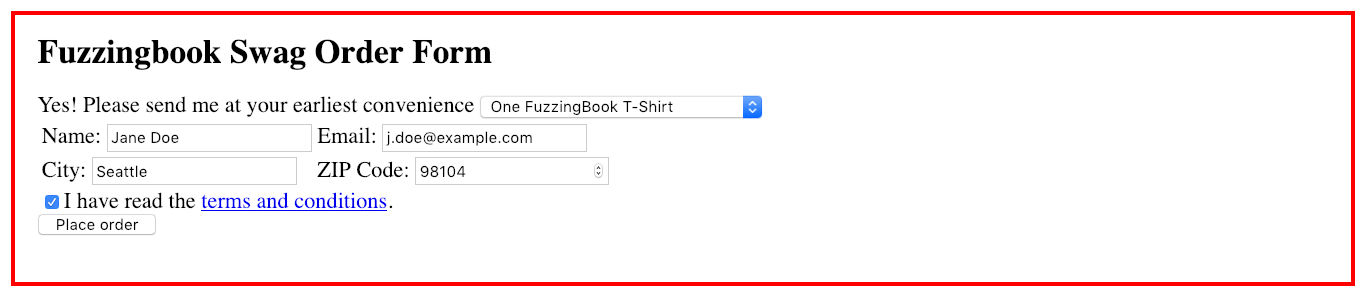

In [26]:
Image(driver.get_screenshot_as_png())

In [27]:
submit = driver.find_element_by_name('submit')
submit.click()

In [28]:
print_httpd_messages()

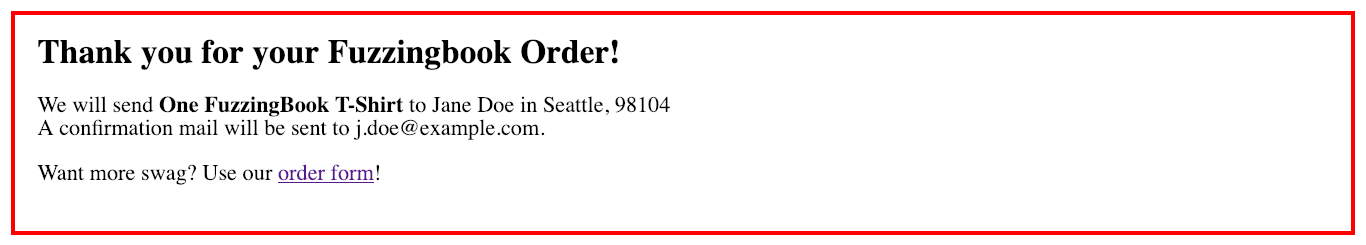

In [29]:
Image(driver.get_screenshot_as_png())

### Navigating

In [30]:
driver.back()

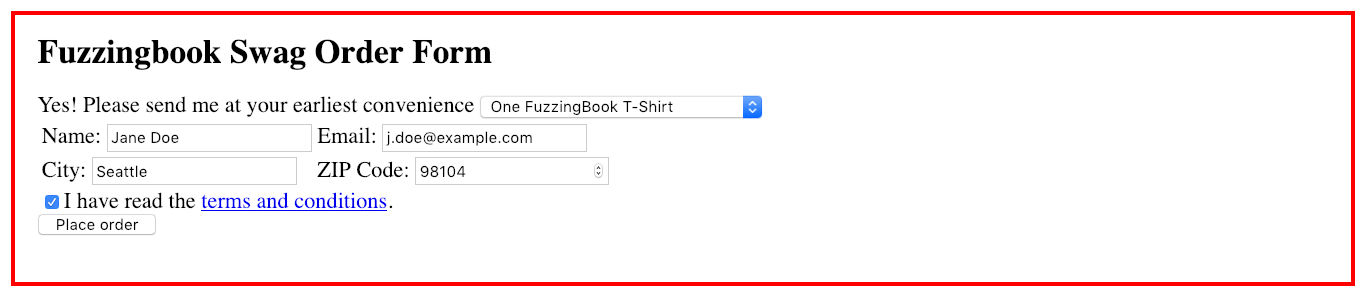

In [31]:
Image(driver.get_screenshot_as_png())

In [32]:
links = driver.find_elements_by_tag_name("a")

In [33]:
links[0].get_attribute('href')

'http://127.0.0.1:8800/terms'

In [34]:
links[0].click()

In [35]:
print_httpd_messages()

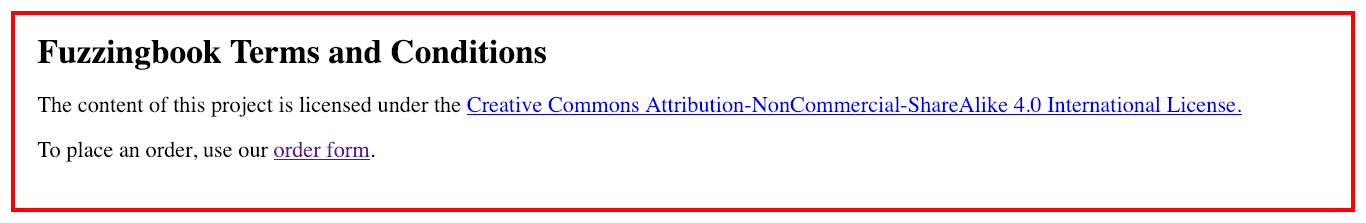

In [36]:
Image(driver.get_screenshot_as_png())

In [37]:
driver.back()

In [38]:
print_httpd_messages()

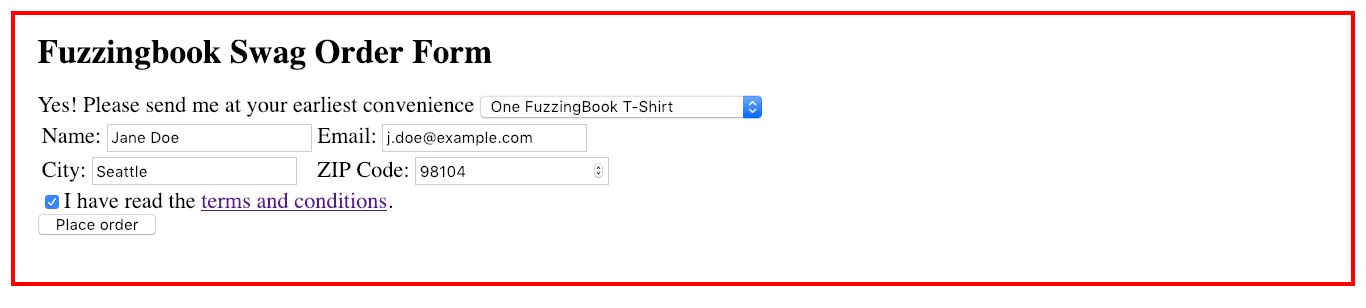

In [39]:
Image(driver.get_screenshot_as_png())

## Retrieving UI Elements

In [40]:
driver.get(httpd_url)

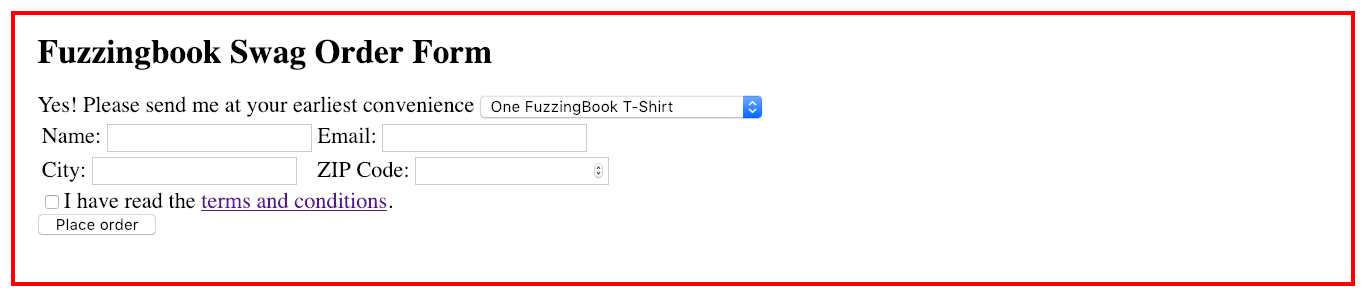

In [41]:
Image(driver.get_screenshot_as_png())

In [42]:
ui_elements = driver.find_elements_by_tag_name("input")

In [43]:
for element in ui_elements:
    print(element.get_attribute('name'), element.get_attribute('type'), element.text)

name text 
email email 
city text 
zip number 
terms checkbox 
submit submit 


In [44]:
from selenium.common.exceptions import StaleElementReferenceException

In [45]:
ui_elements = driver.find_elements_by_tag_name("button")

In [46]:
for element in ui_elements:
    print(element.get_attribute('name'), element.get_attribute('type'), element.text)

In [47]:
class GUIGrammarMiner(object):
    def __init__(self, driver, stay_on_host=True):
        self.driver = driver
        self.stay_on_host = stay_on_host
        self.grammar = {}

In [48]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_state_actions(self):
        return frozenset(self.mine_input_actions()
            | self.mine_button_actions()
            | self.mine_a_actions())

In [49]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_input_actions(self):
        actions = set()
        
        for elem in self.driver.find_elements_by_tag_name("input"):
            try:
                input_type = elem.get_attribute("type")
                input_name = elem.get_attribute("name")
                if input_name is None:
                    input_name = elem.text

                if input_type in ["checkbox", "radio"]:
                    actions.add("check('%s', <boolean>)" % html.escape(input_name))
                elif input_type in ["text", "number", "email", "password"]:
                    actions.add("fill('%s', '<%s>')" % (html.escape(input_name), html.escape(input_type)))
                elif input_type in ["button", "submit"]:
                    actions.add("submit('%s')" % html.escape(input_name))
                elif input_type in ["hidden"]:
                    pass
                else:
                    # TODO: Handle more types here
                    actions.add("fill('%s', <%s>)" % (html.escape(input_name), html.escape(input_type)))
            except StaleElementReferenceException:
                pass

        return actions

In [50]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_button_actions(self):
        actions = set()
        
        for elem in self.driver.find_elements_by_tag_name("button"):
            try:
                button_type = elem.get_attribute("type")
                button_name = elem.get_attribute("name")
                if button_name is None:
                    button_name = elem.text
                if button_type == "submit":
                    actions.add("submit('%s')" % html.escape(button_name))
                elif button_type != "reset":
                    actions.add("click('%s')" % html.escape(button_name))
            except StaleElementReferenceException:
                pass

        return actions

In [51]:
class GUIGrammarMiner(GUIGrammarMiner):
    def mine_a_actions(self):
        actions = set()

        for elem in self.driver.find_elements_by_tag_name("a"):
            try:
                a_href = elem.get_attribute("href")
                if a_href is not None:
                    if self.follow_link(a_href):
                        actions.add("click('%s')" % html.escape(elem.text))
                    else:
                        actions.add("ignore('%s')" % html.escape(elem.text))
            except StaleElementReferenceException:
                pass

        return actions

In [52]:
from urllib.parse import urljoin, urlsplit

In [53]:
class GUIGrammarMiner(GUIGrammarMiner):
    def follow_link(self, link):
        if not self.stay_on_host:
            return True
        
        current_url = self.driver.current_url
        target_url = urljoin(current_url, link)
        return urlsplit(current_url).hostname == urlsplit(target_url).hostname       

In [54]:
gui_grammar_miner = GUIGrammarMiner(driver)

In [55]:
gui_grammar_miner.follow_link("ftp://foo.bar/")

False

In [56]:
gui_grammar_miner.follow_link("https://127.0.0.1/")

True

In [57]:
gui_grammar_miner = GUIGrammarMiner(driver)
gui_grammar_miner.mine_state_actions()

frozenset({"check('terms', <boolean>)",
           "click('terms and conditions')",
           "fill('city', '<text>')",
           "fill('email', '<email>')",
           "fill('name', '<text>')",
           "fill('zip', '<number>')",
           "submit('submit')"})

This set of interactive elements makes up a _page_.

## Systematic GUI Exploration

### Representing States as Grammars

\todo{}: Have a generic interface `BaseGrammarMiner` with `__init__()` and `mine_grammar()`

In [58]:
from Grammars import new_symbol

In [59]:
from Grammars import nonterminals, START_SYMBOL
from Grammars import extend_grammar, unreachable_nonterminals, opts, crange, srange
from Grammars import syntax_diagram, is_valid_grammar

In [60]:
from WebFuzzer import HTMLGrammarMiner

In [61]:
class GUIGrammarMiner(GUIGrammarMiner):
    START_STATE = "<state>"
    UNEXPLORED_STATE = "<unexplored>"
    FINAL_STATE = "<end>"

    GUI_GRAMMAR = ({
        START_SYMBOL: [START_STATE],
        UNEXPLORED_STATE: [""],
        FINAL_STATE: [""],

        "<text>": ["<string>"],
        "<string>": ["<character>", "<string><character>"],
        "<character>": ["<letter>", "<digit>", "<special>"],
        "<letter>": crange('a', 'z') + crange('A', 'Z'),
        
        "<number>": ["<digits>"],
        "<digits>": ["<digit>", "<digits><digit>"],
        "<digit>": crange('0', '9'),
        
        "<special>": srange(". !"),

        "<email>": ["<letters>@<letters>"],
        "<letters>": ["<letter>", "<letters><letter>"],
        
        "<boolean>": ["True", "False"],

        # Use a fixed password in case we need to repeat it
        "<password>": ["abcABC.123"],
        
        "<hidden>": "<string>",
    })

start


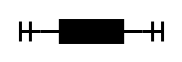

unexplored


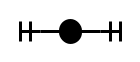

end


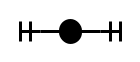

text


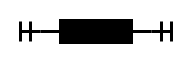

string


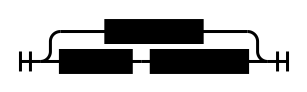

character


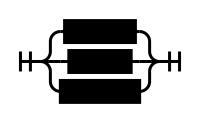

letter


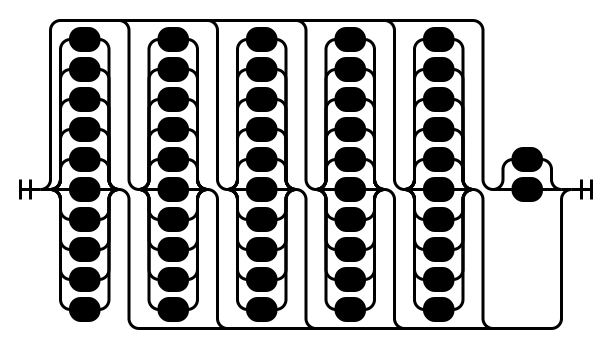

number


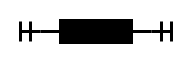

digits


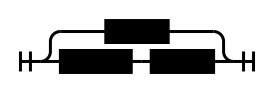

digit


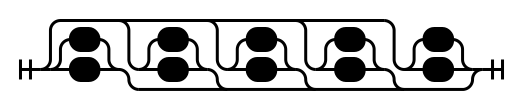

special


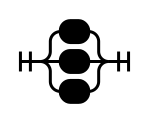

email


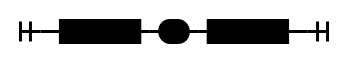

letters


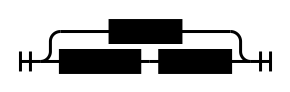

boolean


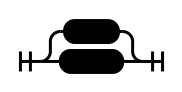

password


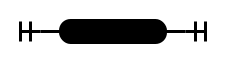

hidden


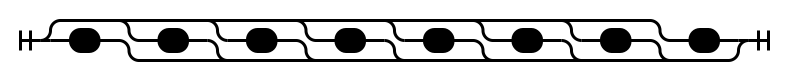

In [62]:
syntax_diagram(GUIGrammarMiner.GUI_GRAMMAR)

In [63]:
class GUIGrammarMiner(GUIGrammarMiner):
    def new_state_symbol(self, grammar):
        return new_symbol(grammar, self.START_STATE)

    def mine_state_grammar(self, grammar={}, state_symbol=None):
        grammar = extend_grammar(self.GUI_GRAMMAR, grammar)

        if state_symbol is None:
            state_symbol = self.new_state_symbol(grammar)
            grammar[state_symbol] = []

        alternatives = []
        form = ""
        submit = None

        for action in self.mine_state_actions():
            if action.startswith("submit"):
                submit = action
                
            elif action.startswith("click"):
                link_target = self.new_state_symbol(grammar)
                grammar[link_target] = [self.UNEXPLORED_STATE]
                alternatives.append(action + '\n' + link_target)
                
            elif action.startswith("ignore"):
                pass

            else:  # fill(), check() actions
                if len(form) > 0:
                    form += '\n'
                form += action

        if submit is not None:
            if len(form) > 0:
                form += '\n'
            form += submit

        if len(form) > 0:
            form_target = self.new_state_symbol(grammar)
            grammar[form_target] = [self.UNEXPLORED_STATE]
            alternatives.append(form + '\n' + form_target)
            
        alternatives += [self.FINAL_STATE]

        grammar[state_symbol] = alternatives
        
        # Remove unused parts
        for nonterminal in unreachable_nonterminals(grammar):
            del grammar[nonterminal]

        assert is_valid_grammar(grammar)
        
        return grammar

In [64]:
gui_grammar_miner = GUIGrammarMiner(driver)
state_grammar = gui_grammar_miner.mine_state_grammar()
state_grammar

{'<start>': ['<state>'],
 '<unexplored>': [''],
 '<end>': [''],
 '<text>': ['<string>'],
 '<string>': ['<character>', '<string><character>'],
 '<character>': ['<letter>', '<digit>', '<special>'],
 '<letter>': ['a',
  'b',
  'c',
  'd',
  'e',
  'f',
  'g',
  'h',
  'i',
  'j',
  'k',
  'l',
  'm',
  'n',
  'o',
  'p',
  'q',
  'r',
  's',
  't',
  'u',
  'v',
  'w',
  'x',
  'y',
  'z',
  'A',
  'B',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'J',
  'K',
  'L',
  'M',
  'N',
  'O',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'U',
  'V',
  'W',
  'X',
  'Y',
  'Z'],
 '<number>': ['<digits>'],
 '<digits>': ['<digit>', '<digits><digit>'],
 '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],
 '<special>': ['.', ' ', '!'],
 '<email>': ['<letters>@<letters>'],
 '<letters>': ['<letter>', '<letters><letter>'],
 '<boolean>': ['True', 'False'],
 '<state>': ["click('terms and conditions')\n<state-1>",
  "check('terms', <boolean>)\nfill('email', '<email>')\nfill('city', '<text>')\nfill

In [65]:
state_grammar[GUIGrammarMiner.START_STATE]

["click('terms and conditions')\n<state-1>",
 "check('terms', <boolean>)\nfill('email', '<email>')\nfill('city', '<text>')\nfill('name', '<text>')\nfill('zip', '<number>')\nsubmit('submit')\n<state-2>",
 '<end>']

The grammar actually encodes a Finite State Machine:

In [66]:
from graphviz import Digraph
from IPython.display import display
from GrammarFuzzer import dot_escape
from collections import deque

In [67]:
def fsm_diagram(grammar, start_symbol=START_SYMBOL):
    def left_align(label):
        return dot_escape(label.replace('\n', r'\l')).replace(r'\\l', '\\l')

    dot = Digraph(comment="Grammar as Finite State Machine")

    symbols = deque([start_symbol])
    symbols_seen = set()
    
    while len(symbols) > 0:
        symbol = symbols.popleft()
        symbols_seen.add(symbol)
        dot.node(symbol, dot_escape(unicode_escape(symbol)))
        
        for expansion in grammar[symbol]:
            nts = nonterminals(expansion)
            if len(nts) > 0:
                target_symbol = nts[-1]
                if target_symbol not in symbols_seen:
                    symbols.append(target_symbol)

                label = expansion.replace(target_symbol, '')
                dot.edge(symbol, target_symbol, left_align(unicode_escape(label)))
                         
                
    return display(dot)

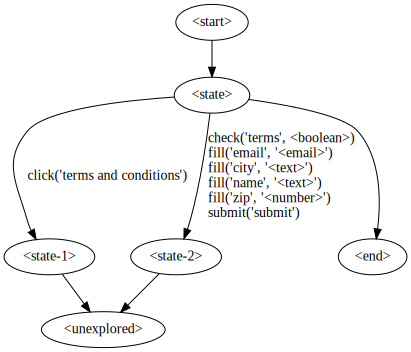

In [68]:
fsm_diagram(state_grammar)

In [69]:
# Remove unused parts
for nonterminal in unreachable_nonterminals(state_grammar):
    del state_grammar[nonterminal]

In [70]:
from GeneratorGrammarFuzzer import GeneratorGrammarFuzzer

In [71]:
gui_fuzzer = GeneratorGrammarFuzzer(state_grammar)
print(gui_fuzzer.fuzz())

click('terms and conditions')



### Fuzzing GUI Forms

In [72]:
from Fuzzer import Runner

In [73]:
class GUIRunner(Runner):
    def __init__(self, driver):
        self.driver = driver
        
    def run(self, inp):
        def fill(name, value):
            self.do_fill(html.unescape(name), html.unescape(value))
        def check(name, state):
            self.do_check(html.unescape(name), state)
        def submit(name):
            self.do_submit(html.unescape(name))
        def click(name):
            self.do_click(html.unescape(name))
        
        exec(inp, {}, {'fill': fill, 'check': check, 
                       'submit': submit, 'click': click})
        
        return inp, self.PASS

In [74]:
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException, ElementNotInteractableException

In [75]:
class GUIRunner(GUIRunner):
    def find_element(self, name):
        try:
            return self.driver.find_element_by_name(name)
        except NoSuchElementException:
            return self.driver.find_element_by_link_text(name)

We need delays (in seconds):

In [76]:
from selenium.webdriver.support.ui import WebDriverWait

In [77]:
class GUIRunner(GUIRunner):
    DELAY_AFTER_FILL = 0.1
    DELAY_AFTER_CHECK = 0.1
    DELAY_AFTER_SUBMIT = 1
    DELAY_AFTER_CLICK = 1

In [78]:
class GUIRunner(GUIRunner):
    def do_fill(self, name, value):
        element = self.find_element(name)
        element.send_keys(value)
        WebDriverWait(self.driver, self.DELAY_AFTER_FILL)

In [79]:
class GUIRunner(GUIRunner):
    def do_check(self, name, state):
        element = self.find_element(name)
        if bool(state) != bool(element.is_selected()):
            element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_CHECK)

In [80]:
class GUIRunner(GUIRunner):
    def do_submit(self, name):
        element = self.find_element(name)
        element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_SUBMIT)

In [81]:
class GUIRunner(GUIRunner):
    def do_click(self, name):
        element = self.find_element(name)
        element.click()
        WebDriverWait(self.driver, self.DELAY_AFTER_CLICK)

In [82]:
driver.get(httpd_url)

In [83]:
gui_runner = GUIRunner(driver)

In [84]:
gui_runner.run("fill('name', 'Walter White')")

("fill('name', 'Walter White')", 'PASS')

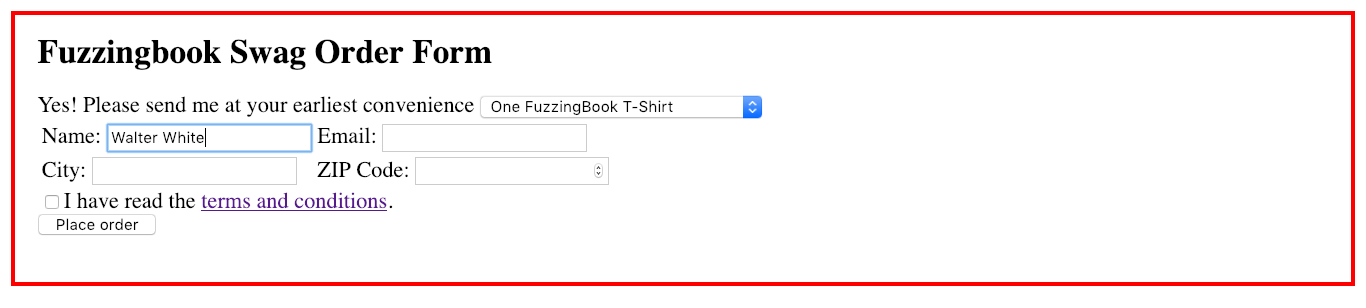

In [85]:
Image(driver.get_screenshot_as_png())

In [86]:
gui_runner.run("submit('submit')")

("submit('submit')", 'PASS')

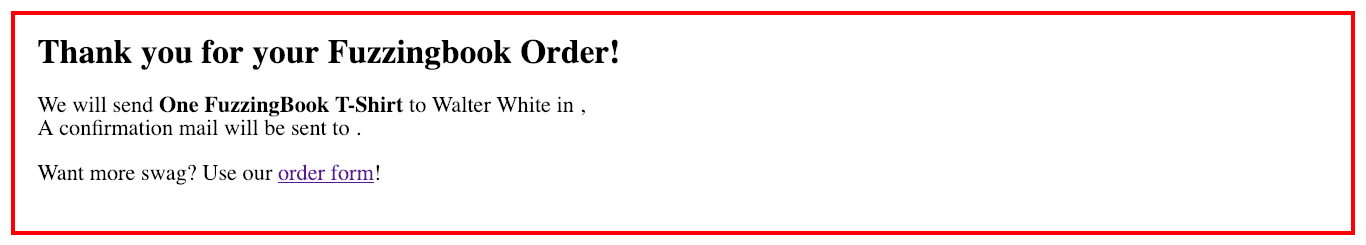

In [87]:
Image(driver.get_screenshot_as_png())

In [88]:
driver.get(httpd_url)

In [89]:
gui_fuzzer = GeneratorGrammarFuzzer(state_grammar)

In [90]:
while True:
    action = gui_fuzzer.fuzz()
    if action.find('submit(') > 0:
        break

In [91]:
print(action)

check('terms', False)
fill('email', 'Z@gwd')
fill('city', 'c')
fill('name', '.')
fill('zip', '89')
submit('submit')



In [92]:
gui_runner.run(action)

("check('terms', False)\nfill('email', 'Z@gwd')\nfill('city', 'c')\nfill('name', '.')\nfill('zip', '89')\nsubmit('submit')\n",
 'PASS')

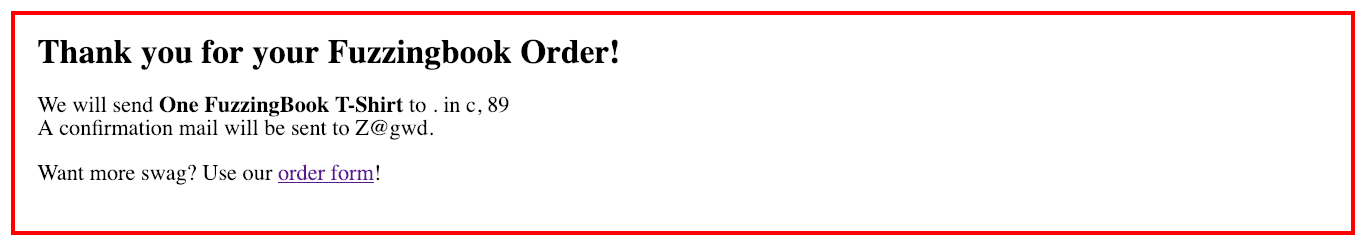

In [93]:
Image(driver.get_screenshot_as_png())

### Exploring States

In [94]:
from Grammars import is_nonterminal

In [95]:
from GrammarCoverageFuzzer import GrammarCoverageFuzzer

In [96]:
class GUIFuzzer(GrammarCoverageFuzzer):
    def __init__(self, driver, 
                 stay_on_host=True,
                 log_gui_exploration=False, 
                 disp_gui_exploration=False, 
                 **kwargs):
        self.driver = driver
        self.miner = GUIGrammarMiner(driver)
        self.stay_on_host = True
        self.log_gui_exploration = log_gui_exploration
        self.disp_gui_exploration = disp_gui_exploration
        self.initial_url = driver.current_url

        self.states_seen = {}  # Maps states to symbols
        self.state_symbol = GUIGrammarMiner.START_STATE
        self.state = self.miner.mine_state_actions()
        self.states_seen[self.state] = self.state_symbol
        
        grammar = self.miner.mine_state_grammar()
        super().__init__(grammar, **kwargs)

In [97]:
class GUIFuzzer(GUIFuzzer):
    def restart(self):
        self.driver.get(self.initial_url)
        self.state = GUIGrammarMiner.START_STATE

In [98]:
class GUIFuzzer(GUIFuzzer):
    def fsm_path(self, tree):
        """Return sequence of state symbols"""
        (node, children) = tree
        if node == GUIGrammarMiner.UNEXPLORED_STATE:
            return []
        elif children is None or len(children) == 0:
            return [node]
        else:
            return [node] + self.fsm_path(children[-1])

In [99]:
class GUIFuzzer(GUIFuzzer):
    def fsm_last_state_symbol(self, tree):
        """Return current (expected) state symbol"""
        for state in reversed(self.fsm_path(tree)):
            if is_nonterminal(state):
                return state
        assert False

In [100]:
class GUIFuzzer(GUIFuzzer):
    def run(self, gui_runner):
        assert isinstance(gui_runner, GUIRunner)
        
        self.restart()
        action = self.fuzz()
        self.state_symbol = self.fsm_last_state_symbol(self.derivation_tree)

        if self.log_gui_exploration:
            print("Action", action.strip(), "->", self.state_symbol)

        result, outcome = gui_runner.run(action)
        
        if self.state_symbol != GUIGrammarMiner.FINAL_STATE:
            self.update_state()

        return self.state_symbol, outcome

In [101]:
class GUIFuzzer(GUIFuzzer):
    def update_state(self):
        if self.disp_gui_exploration:
            display(Image(self.driver.get_screenshot_as_png()))

        self.state = self.miner.mine_state_actions()
        if self.state not in self.states_seen:
            self.states_seen[self.state] = self.state_symbol
            self.update_new_state()
        else:
            self.update_existing_state()

In [102]:
class GUIFuzzer(GUIFuzzer):
    def set_grammar(self, new_grammar):
        self.grammar = new_grammar
        
        if self.disp_gui_exploration and rich_output():
            display(fsm_diagram(self.grammar))

In [103]:
class GUIFuzzer(GUIFuzzer):
    def update_new_state(self):
        if self.log_gui_exploration:
            print("In new state", unicode_escape(self.state_symbol), unicode_escape(repr(self.state)))

        state_grammar = self.miner.mine_state_grammar(grammar=self.grammar, 
                                                      state_symbol=self.state_symbol)
        del state_grammar[START_SYMBOL]
        del state_grammar[GUIGrammarMiner.START_STATE]
        self.set_grammar(extend_grammar(self.grammar, state_grammar))

In [104]:
from Grammars import exp_string, exp_opts

In [105]:
def replace_symbol(grammar, old_symbol, new_symbol):
    """Return a grammar in which all occurrences of `old_symbol` are replaced by `new_symbol`"""
    new_grammar = {}
    
    for symbol in grammar:
        new_expansions = []
        for expansion in grammar[symbol]:
            new_expansion_string = exp_string(expansion).replace(old_symbol, new_symbol)
            if len(exp_opts(expansion)) > 0:
                new_expansion = (new_expansion_string, exp_opts(expansion))
            else:
                new_expansion = new_expansion_string
            new_expansions.append(new_expansion)
                
        new_grammar[symbol] = new_expansions
        
    # Remove unused parts
    for nonterminal in unreachable_nonterminals(new_grammar):
        del new_grammar[nonterminal]

    return new_grammar

In [106]:
class GUIFuzzer(GUIFuzzer):            
    def update_existing_state(self):
        if self.log_gui_exploration:
            print("In existing state", self.states_seen[self.state])

        if self.state_symbol != self.states_seen[self.state]:
            if self.log_gui_exploration:
                print("Replacing expected state %s by %s" %
                      (self.state_symbol, self.states_seen[self.state]))
            
            new_grammar = replace_symbol(self.grammar, self.state_symbol, 
                                         self.states_seen[self.state])
            self.state_symbol = self.states_seen[self.state]
            self.set_grammar(new_grammar)

In [107]:
driver.get(httpd_url)

In [108]:
gui_fuzzer = GUIFuzzer(driver, log_gui_exploration=True, disp_gui_exploration=True)

In [109]:
gui_fuzzer.fuzz()

"click('terms and conditions')\n"

In [110]:
from GrammarFuzzer import display_tree

In [111]:
gui_fuzzer.run(gui_runner)

Action  -> <end>


('<end>', 'PASS')

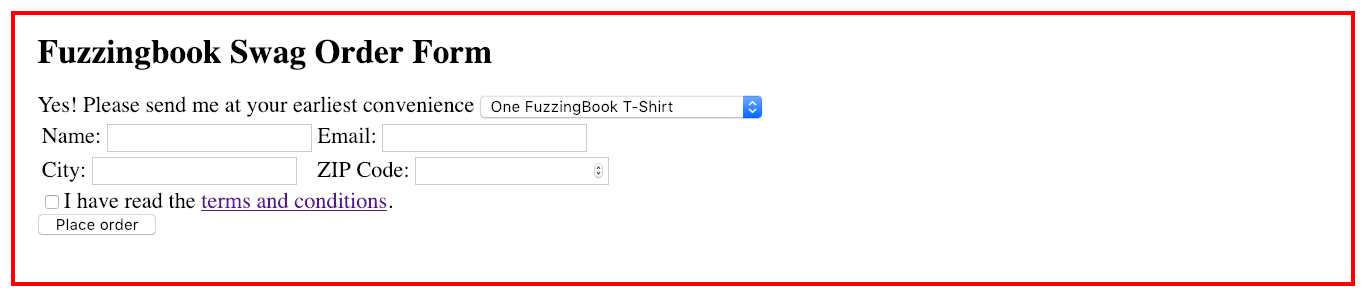

In [112]:
Image(driver.get_screenshot_as_png())

In [113]:
gui_fuzzer.restart()

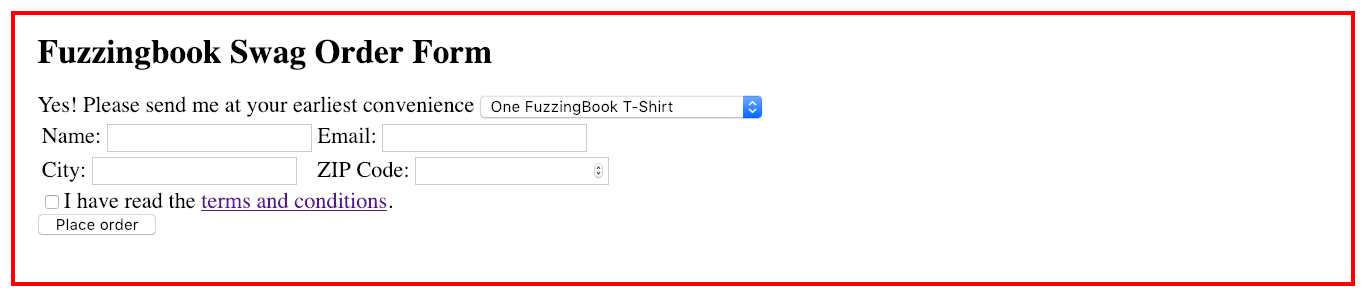

In [114]:
Image(driver.get_screenshot_as_png())

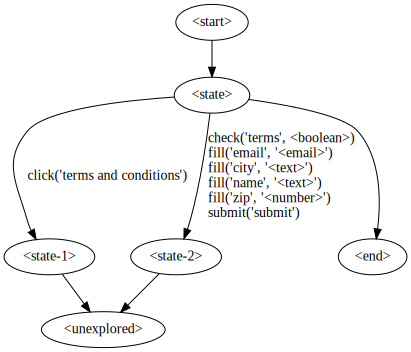

In [115]:
fsm_diagram(gui_fuzzer.grammar)

In [116]:
class GUIFuzzer(GUIFuzzer):            
    def explore_all(self, runner, max_actions=100):
        actions = 0
        while GUIGrammarMiner.UNEXPLORED_STATE in self.grammar and actions < max_actions:
            actions += 1
            if self.log_gui_exploration:
                print("Run #" + repr(actions))
            try:
                self.run(runner)
            except ElementClickInterceptedException:
                pass
            except ElementNotInteractableException:
                pass
            except NoSuchElementException:
                pass

In [117]:
gui_fuzzer = GUIFuzzer(driver)

In [118]:
gui_fuzzer.explore_all(gui_runner)

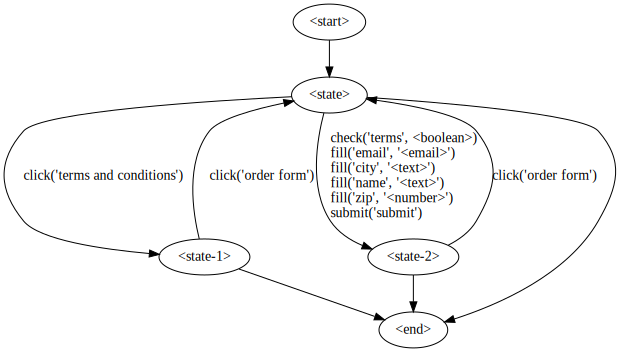

In [119]:
fsm_diagram(gui_fuzzer.grammar)

## Covering States

In [120]:
gui_fuzzer.covered_expansions

{'<boolean> -> False',
 '<boolean> -> True',
 '<character> -> <digit>',
 '<character> -> <letter>',
 '<character> -> <special>',
 '<digit> -> 1',
 '<digit> -> 2',
 '<digit> -> 3',
 '<digit> -> 4',
 '<digit> -> 9',
 '<digits> -> <digit>',
 '<digits> -> <digits><digit>',
 '<email> -> <letters>@<letters>',
 '<end> -> ',
 '<letter> -> A',
 '<letter> -> C',
 '<letter> -> I',
 '<letter> -> K',
 '<letter> -> N',
 '<letter> -> P',
 '<letter> -> U',
 '<letter> -> W',
 '<letter> -> Z',
 '<letter> -> c',
 '<letter> -> d',
 '<letter> -> j',
 '<letter> -> l',
 '<letter> -> q',
 '<letter> -> u',
 '<letter> -> w',
 '<letter> -> x',
 '<letter> -> y',
 '<letters> -> <letter>',
 '<letters> -> <letters><letter>',
 '<number> -> <digits>',
 '<special> ->  ',
 '<start> -> <state>',
 '<state-1> -> <unexplored>',
 "<state-1> -> click('order form')\n<state-3>",
 '<state-2> -> <unexplored>',
 "<state-2> -> click('order form')\n<state-4>",
 '<state-3> -> <unexplored>',
 '<state-4> -> <unexplored>',
 '<state> -> 

In [121]:
gui_fuzzer.missing_expansion_coverage()

{'<digit> -> 0',
 '<digit> -> 5',
 '<digit> -> 6',
 '<digit> -> 7',
 '<digit> -> 8',
 '<letter> -> B',
 '<letter> -> D',
 '<letter> -> E',
 '<letter> -> F',
 '<letter> -> G',
 '<letter> -> H',
 '<letter> -> J',
 '<letter> -> L',
 '<letter> -> M',
 '<letter> -> O',
 '<letter> -> Q',
 '<letter> -> R',
 '<letter> -> S',
 '<letter> -> T',
 '<letter> -> V',
 '<letter> -> X',
 '<letter> -> Y',
 '<letter> -> a',
 '<letter> -> b',
 '<letter> -> e',
 '<letter> -> f',
 '<letter> -> g',
 '<letter> -> h',
 '<letter> -> i',
 '<letter> -> k',
 '<letter> -> m',
 '<letter> -> n',
 '<letter> -> o',
 '<letter> -> p',
 '<letter> -> r',
 '<letter> -> s',
 '<letter> -> t',
 '<letter> -> v',
 '<letter> -> z',
 '<special> -> !',
 '<special> -> .',
 '<state-1> -> <end>',
 "<state-1> -> click('order form')\n<state>",
 '<state-2> -> <end>',
 "<state-2> -> click('order form')\n<state>"}

### Optimizations

\todo{Special challenge: We need to go back to get to earlier state.}

In [122]:
httpd_process.terminate()

In [123]:
del gui_fuzzer

In [124]:
del gui_runner

## Fun with FuzzingBook

\todo{Create a full map of fuzzingbook.org, only by navigating}

In [125]:
driver.get("https://www.fuzzingbook.org/")

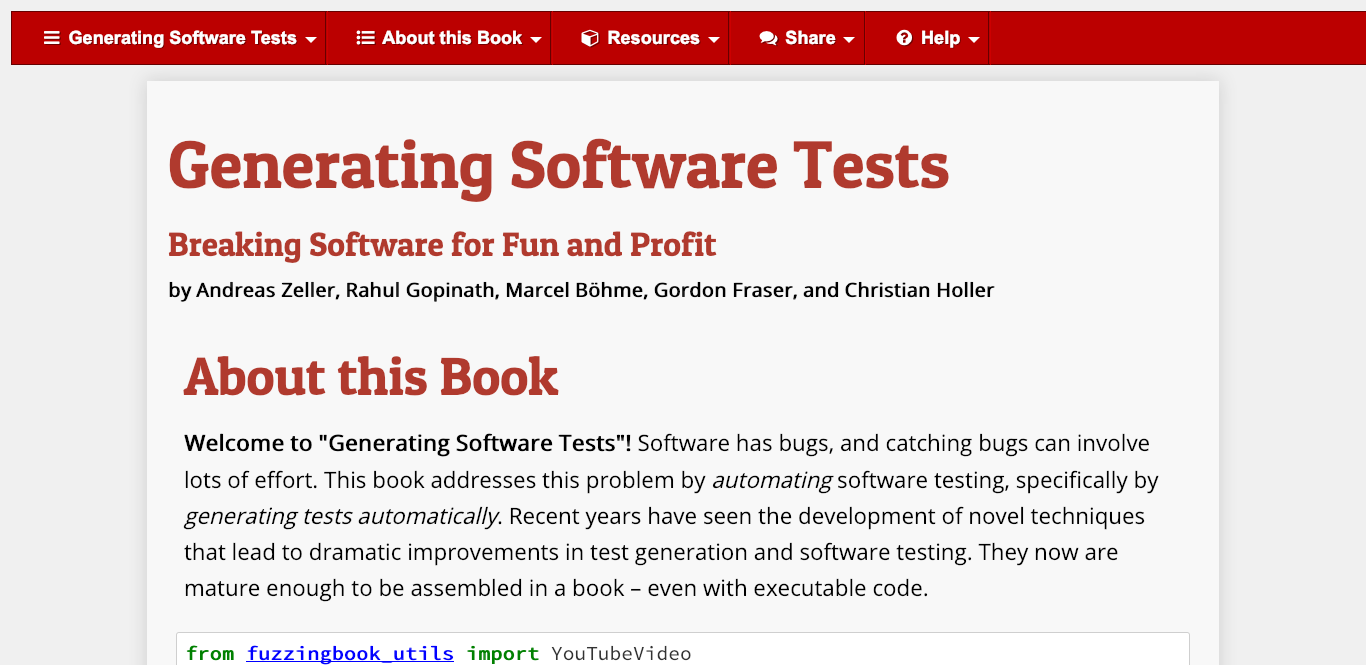

In [126]:
Image(driver.get_screenshot_as_png())

In [127]:
book_runner = GUIRunner(driver)

In [128]:
book_fuzzer = GUIFuzzer(driver, log_gui_exploration=True)  # , disp_gui_exploration=True)

In [129]:
book_fuzzer.initial_url

'https://www.fuzzingbook.org/'

In [130]:
driver.get("https://www.fuzzingbook.org/")

In [131]:
book_fuzzer.explore_all(book_runner, max_actions=10)

Run #1
Action click('Resources') -> <state-4>
In new state <state-4> frozenset({"click('introduction to fuzzing')", "click('Generating Software Tests')", "click('')", "ignore('follow us on Twitter')", "click('Resources')", "click('Parsing and Recombining Inputs')", "click('Fuzzing with Generators')", "click('Guide for Authors')", "click('install and run your own hub.')", "ignore('')", "click('All Notebooks (.zip)')", "ignore('how to install jupyter notebook on your machine')", "click('Introduction to Software Testing')", "click('Help')", "click('do not rely on mybinder.org')", "ignore('Try interacting with the introduction to fuzzing.')", "click('Reducing Failure-Inducing Inputs')", "ignore('Edit Notebooks (beta)')", "click('Mining Input Grammars')", "ignore('Project Page')", "click('Fuzzing: Breaking Things with Random Inputs')", "ignore('fuzzingbook_utils')", "click('Probabilistic Grammar Fuzzing')", "click('introduction to testing')", "ignore('mybinder.org status and reliability pag

That's it – we're done!

In [132]:
fsm_diagram(book_fuzzer.grammar)

## Cleaning up

In [133]:
driver.quit()

In [134]:
import os

In [135]:
for temp_file in [ORDERS_DB, "geckodriver.log", "ghostdriver.log"]:
    if os.path.exists(temp_file):
        os.remove(temp_file)

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

1. Combinatorial testing: Extend the grammar miner such that for every boolean value, there is a separate value to be covered.

2. During testing, prefer paths to yet uncovered states.

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [136]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

In [137]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

### Exercise 2: _Title_

_Text of the exercise_